<script>
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1.0 !important; }</style>';
</script>
<!--# STAT 207: Data Science Exploration-->

# <u>Case Study 15</u>: Classification Accuracy of Classifier Models

In this Case Study, we will again model approval of the President's Foreign Policy with Age and Sex

**<u>Model 1</u>**
In the beginning of this analysis we will model the following response variable with the following explanatory variable.
* <u>response</u>: approval of the president's foreign policy (approve vs. disapprove)
    - age

In attempt to improve our classification accuracy of the previous model, we will introduce a new model with more explanatory variables.
**<u>Model 2</u>**
* <u>response</u>: approval of the president's foreign policy (approve vs. disapprove)
* <u>explanatory</u>:
    - sex
    - age
    - party

Will model 2 outperform model 1 in terms of classification accuracy? How do we measure how well each of these models classified the observations in the sample?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Preparing our Data

Let's again examine our random sample of adults living in the U.S. (from 2017) from Pew Research. We will just use three variables for this analysis, so we will just create a dataframe using these three variables.

In [2]:
missing_values = ["NaN", "nan", "Don't know/Refused (VOL.)"]
#
df = pd.read_csv('Feb17public.csv', na_values=missing_values)[['age','sex','q5cf1']]
df.head()

,age,sex,q5cf1
0,80.0,Female,NaN
1,70.0,Female,Disapprove
2,69.0,Female,Disapprove
3,50.0,Male,NaN
4,70.0,Female,Disapprove


In [3]:
df.shape

(1503, 3)

In [4]:
df=df.dropna()
df.head()

,age,sex,q5cf1
1,70.0,Female,Disapprove
2,69.0,Female,Disapprove
4,70.0,Female,Disapprove
6,89.0,Female,Disapprove
7,92.0,Female,Approve


In [5]:
df.shape

(691, 3)

In [6]:
df['y']=df['q5cf1'].map({'Disapprove':0,'Approve':1})
df.head()

,age,sex,q5cf1,y
1,70.0,Female,Disapprove,0
2,69.0,Female,Disapprove,0
4,70.0,Female,Disapprove,0
6,89.0,Female,Disapprove,0
7,92.0,Female,Approve,1


## Fitting Our Model

Let's first fit a logistic regression model to predict the probability of a person in the sample approving of the president's foreign policy based on age.

Because we only have an explanatory variable (age) and a response variable (y), we can plot the logistic regression curve over the scatterplot of these observations in the sample.

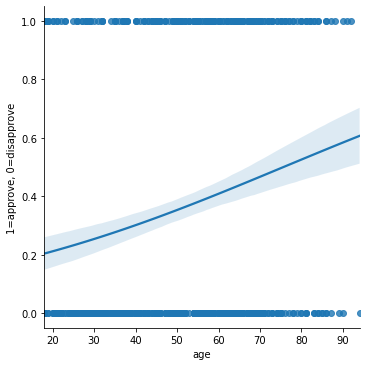

In [7]:
sns.lmplot(x="age", y='y',data=df, logistic=True)
plt.ylabel('1=approve, 0=disapprove')
plt.show()

The equation for this logistic regression model is the following:

$log⁡(\frac{\hat{p}}{1-\hat{p}}   )=-1.7872+0.0236(age)$.

And we can rewrite this equation in another way as well to directly show us the predictive probability for a given age:

$\hat{p} = \frac{e^{-1.7872+0.0236(age)}}{e^{-1.7872+0.0236(age)}+1}$

In [8]:
mod1 = smf.logit(formula='y ~ age', data=df).fit()
mod1.summary()

Optimization terminated successfully.
         Current function value: 0.633703
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  691
Model:                          Logit   Df Residuals:                      689
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Apr 2021   Pseudo R-squ.:                 0.03047
Time:                        13:28:06   Log-Likelihood:                -437.89
converged:                       True   LL-Null:                       -451.65
Covariance Type:            nonrobust   LLR p-value:                 1.553e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7872      0.254     -7.023      0.000      -2.286      -1.288
age            0.0236      0.005      5.128      0.000       0.015       0.033
==============================================================================
"""

### Predictive Probability Calculations

What is the predictive probability of a 70-year-old approving of the president's foreign policy (using this fitted logistic regression model)?

In [9]:
mod1.predict(exog=dict(age=70))

0    0.466859
dtype: float64

The probability that a 70 year old approves of the president's foreign policy (in this random sample of adults living in the U.S. in 2017) is 0.466859.

## Classifying Observations

We know that we can calculate a predictive probability for an individual observation using a logistic regression model.  How can we use that <u>predictive probability</u> to <u>classify</u> a given observation using a logistic regression model?

We'll need a threshold in order to separate our predictive probability into two classes.

If we use a predictive probability threshold of $p_0=0.5$ for this given logistic regression model (ie. classifier model), what opinion will we classifiy this 70-year-old as having?

Because $0.466859\leq p_0=0.5$, we classify this person with y=0 (or that they disapprove of the president's foreign policy).

Using this predictive probability threshold of p_0=0.5, what is the **minimum age** that a person needs to be in order to be classified as approving the president’s foreign policy in this sample?

What value of age satisfies this inequality?
$\hat{p}=\frac{e^{-1.7872+0.0236(age)}}{e^{-1.7872+0.0236(age)}+1}>0.5$.


$log⁡(\frac{0.5}{1-0.5}   )< -1.7872+0.0236(age)$.

$age>75.7288$.

In [10]:
#Plug in 0.5 into your logistic regression equation and solve for age.
threshold_age=(np.log(.5/(1-.5))+1.7872)/.0236
threshold_age

75.72881355932203

## Misclassifications and Correct Classifications

Let's classify ALL of the observations in the sample using this predictive probability threshold of $p_0$ and the logistic regression model.

First we need to get the predictive probabilities for all of the observations in our df dataframe.

We can use the **.predict()** function and simply just input the whole dataframe into the **dict()** function for the **exog** parameter. While the df dataframe has more columns than just **age** in it (ie. our only explanatory variable at the moment in this logistic regression model) the predict function is intelligent enough to know that we only want to extract just the columns values that correspond to the given logistic regression model (mod1).

We add these predictive probabilities as a column in our dataframe.

In [11]:
pred_probabilities=mod1.predict(exog=dict(df)) 
df['predictive_prob']=pred_probabilities
df

,age,sex,q5cf1,y,predictive_prob
1,70.0,Female,Disapprove,0,0.466859
2,69.0,Female,Disapprove,0,0.460982
4,70.0,Female,Disapprove,0,0.466859
6,89.0,Female,Disapprove,0,0.578423
7,92.0,Female,Approve,1,0.595610
...,...,...,...,...,...
1494,23.0,Female,Approve,1,0.223812
1498,37.0,Male,Approve,1,0.286448
1499,30.0,Female,Approve,1,0.253858
1501,67.0,Male,Disapprove,0,0.449260


Then we can create another column in our dataframe that is our classification (or predicted value for y) for each of the observations. To do this we can set up a row condition on the inside of some parantheses.

This (row condition for a dataframe) by itself will produce a series of True or False values depending on whether the condition for that particular row is true or not.

Then by using 1*(row condition for a dataframe), we translate each True to a 1 and each False to a 0.

In [12]:
df['yhat']=1*(df['predictive_prob']>0.5)
df

,age,sex,q5cf1,y,predictive_prob,yhat
1,70.0,Female,Disapprove,0,0.466859,0
2,69.0,Female,Disapprove,0,0.460982,0
4,70.0,Female,Disapprove,0,0.466859,0
6,89.0,Female,Disapprove,0,0.578423,1
7,92.0,Female,Approve,1,0.595610,1
...,...,...,...,...,...,...
1494,23.0,Female,Approve,1,0.223812,0
1498,37.0,Male,Approve,1,0.286448,0
1499,30.0,Female,Approve,1,0.253858,0
1501,67.0,Male,Disapprove,0,0.449260,0


### Visualizing our Classifications

Let's plot our predicted (classified) y-values for the observations (shown in blue and orange) as well as our actual values for y (shown on the y-axis.) 

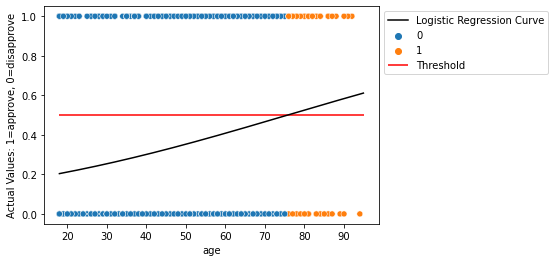

In [13]:
x=np.arange(18,95,.1)
p=np.exp(-1.7872+0.0236*x)/(1+np.exp(-1.7872+0.0236*x))
sns.scatterplot(x="age", y='y',data=df, hue='yhat')
plt.plot(x,p, color='black', label='Logistic Regression Curve')
plt.hlines(y=0.5, xmin=18, xmax=95, color='red', label='Threshold')
plt.ylabel('Actual Values: 1=approve, 0=disapprove')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Confusion Matrix

Next, let's create a confusion matrix for this classifier model and the given threshold.  This records a combination of predicted and actual classifications for the observations in our data.

In [14]:
# This import requires that you already 
# installed the scikit-learn library 
# as described earlier in the course.
#
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [15]:
confusion_matrix(y_true=df['y'], y_pred=df['yhat'])

array([[420,  22],
       [221,  28]], dtype=int64)

### Measures of Classification

In [16]:
tn, fp, fn, tp = confusion_matrix(y_true=df['y'], 
                                  y_pred=df['yhat']).ravel()
(tn, fp, fn, tp)

(420, 22, 221, 28)

What is the **number of true positive, false positive, true negative, and false negative** observations in the sample using the logistic regression model and the predictive threshold of $p_0=0.5$?

What is the **sensitivity** of the logistic regression model with the predictive threshold of $p_0=0.5$ using the sample data?

In [17]:
sensitivity=tp/(tp+fn)
print('sensitivity:', sensitivity)

sensitivity: 0.11244979919678715


This is quite low, which indicates that the logistic regression model with $p_0=0.05$ did not do well at correctly classifying people that actually approved of the president's foreign policy.

What is the **specificity** of the logistic regression model with the predictive threshold of $p_0=0.5$ using the sample data?

In [18]:
specificity=tn/(tn+fp)
print('specificity:', specificity)

specificity: 0.9502262443438914


This is quite high, which indicates that the logistic regression model with $p_0=0.05$ did a pretty good job at correctly classifying people that actually disapproved of the president's foreign policy.

What is the **false positive rate** of the logistic regression model with the predictive threshold of $p_0=0.5$ using the sample data?

In [19]:
false_positive_rate=fp/(tn+fp)
print('false positive rate:', false_positive_rate)

false positive rate: 0.049773755656108594


This is quite low, which indicates that the logistic regression model with $p_0=0.05$ did a pretty good job at correctly classifying people that actually disapproved of the president's foreign policy.

Ideally, both sensitivity and specificity would be high, as we hope that we accurately classify most observations.  However, sensitivity and specificity have an inverse relationship with each other, based on the threshold used for classification.

### Adjusting the Classifier Threshold

Using the same logistic regression model as before, and now a predictive probability threshold of $p_0=0.3$ to classify all of the observations in the sample.

Let's first re-classify our observations in our dataframe with our new threshold of $p_0=0.3$.

In [20]:
df['yhat']=1*(df['predictive_prob']>0.3)
df

,age,sex,q5cf1,y,predictive_prob,yhat
1,70.0,Female,Disapprove,0,0.466859,1
2,69.0,Female,Disapprove,0,0.460982,1
4,70.0,Female,Disapprove,0,0.466859,1
6,89.0,Female,Disapprove,0,0.578423,1
7,92.0,Female,Approve,1,0.595610,1
...,...,...,...,...,...,...
1494,23.0,Female,Approve,1,0.223812,0
1498,37.0,Male,Approve,1,0.286448,0
1499,30.0,Female,Approve,1,0.253858,0
1501,67.0,Male,Disapprove,0,0.449260,1


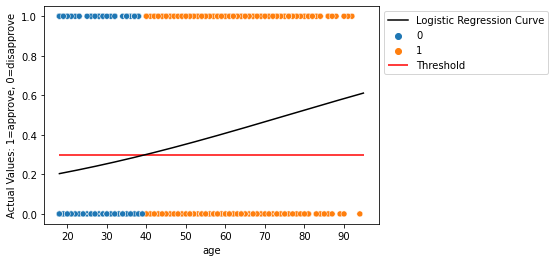

In [21]:
x=np.arange(18,95,.1)
p=np.exp(-1.7872+0.0236*x)/(1+np.exp(-1.7872+0.0236*x))
sns.scatterplot(x="age", y='y',data=df, hue='yhat')
plt.plot(x,p, color='black', label='Logistic Regression Curve')
plt.hlines(y=0.3, xmin=18, xmax=95, color='red', label='Threshold')
plt.ylabel('Actual Values: 1=approve, 0=disapprove')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#### Classification Measure Classifications

Find the sensitivity and specificity for this threshold and classifier. 

In [22]:
tn, fp, fn, tp = confusion_matrix(y_true=df['y'], 
                                  y_pred=df['yhat']).ravel()
(tn, fp, fn, tp)

(172, 270, 51, 198)

In [23]:
sensitivity=tp/(tp+fn)
print('sensitivity:', sensitivity)

sensitivity: 0.7951807228915663


In [24]:
specificity=tn/(tn+fp)
print('specificity:', specificity)

specificity: 0.3891402714932127


## Comparing Classification Thresholds

Which predictive probability threshold yielded better results? $p_0=0.5$ or $p_0=0.3$?

Ideally, we would like both our sensitivty and specificity to be high. However, we know that generally when one of these increases, the other will decrease (based on us changing our predictive probability threshold).

Which of these results is best is dependent on how much we care accurately classifying people that actually approve vs. accurately classifying people that disapprove.

* If we care more about accurately classifying people that actually approve (ie. actually have y=1), we would want to pick the threshold of $p_0=0.3$ that yields a higher sensitivity of 0.795.

* If we care more about accurately classifying people that actually disapprove (ie. actually have y=0), we would want to pick the threshold of $p_0=0.5$ that yields a higher specificity of 0.950.

While we compared only two possible thresholds above, you may consider the situation where we want to determine the *classifier* that will give us the best combination of false positive rate & true positive rate for all sets of thresholds.  We can accomplish this using the <u>ROC and AUC</u>.

### <u>Model 1</u>: Age Model

Using the logistic regression model that predicts approval of presidential foreign policy given age, graph the **ROC curve**

In [25]:
fprs, tprs, thresholds = roc_curve(y_true=df['y'], 
                            y_score=mod1.fittedvalues)
auc = roc_auc_score(y_true=df['y'], 
                    y_score=mod1.fittedvalues)
print(auc)

0.6178832978974722


In [26]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr, tpr, color='darkorange', lw=lw,
             label='ROC curve (area = '+str(round(auc,3))+')')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

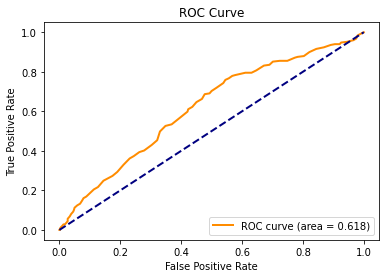

In [27]:
plot_roc(fprs, tprs, auc)

### <u>Model 2</u>: Age and Sex

We will now fit our second model, a logistic regression model that predicts approval of presidential foreign policy from age and sex.

Let's reread the data in again, as we would now like to model approval for the president's foreign policy with age, sex, and party.

In [28]:
missing_values = ["NaN", "nan", "Don't know/Refused (VOL.)"]
#
df = pd.read_csv('Feb17public.csv', na_values=missing_values)[['age','sex','q5cf1','party']]
df.head()

,age,sex,q5cf1,party
0,80.0,Female,NaN,Independent
1,70.0,Female,Disapprove,Democrat
2,69.0,Female,Disapprove,Independent
3,50.0,Male,NaN,Republican
4,70.0,Female,Disapprove,Democrat


In [29]:
df=df.dropna()
df.head()

,age,sex,q5cf1,party
1,70.0,Female,Disapprove,Democrat
2,69.0,Female,Disapprove,Independent
4,70.0,Female,Disapprove,Democrat
6,89.0,Female,Disapprove,Independent
7,92.0,Female,Approve,Republican


In [30]:
df['y']=df['q5cf1'].map({'Disapprove':0,'Approve':1})
df.head()

,age,sex,q5cf1,party,y
1,70.0,Female,Disapprove,Democrat,0
2,69.0,Female,Disapprove,Independent,0
4,70.0,Female,Disapprove,Democrat,0
6,89.0,Female,Disapprove,Independent,0
7,92.0,Female,Approve,Republican,1


In [31]:
mod2 = smf.logit(formula='y ~ age+sex+party', data=df).fit()
mod2.summary()

Optimization terminated successfully.
         Current function value: 0.419649
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  679
Model:                          Logit   Df Residuals:                      672
Method:                           MLE   Df Model:                            6
Date:                Thu, 08 Apr 2021   Pseudo R-squ.:                  0.3614
Time:                        13:28:07   Log-Likelihood:                -284.94
converged:                       True   LL-Null:                       -446.23
Covariance Type:            nonrobust   LLR p-value:                 1.185e-66
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -4.5635      0.465     -9.807      0.000      -5.475      -3.651
sex[T.Male]                       0.7288      0.217      3.363      0.001       0.304       1.154
party[T.Independent]              2.2604      0.312      7.236      0.000       1.648       2.873
party[T.No preference (VOL.)]     2.5881      0.680      3.808      0.000       1.256       3.920
party[T.Other party (VOL.)]       4.0865      1.212      3.372      0.001       1.711       6.462
party[T.Republican]               4.2985      0.341     12.592      0.000       3.629       4.968
age                               0.0272      0.006      4.443      0.000       0.015       0.039
=================================================================================================
"""

In [32]:
fprs, tprs, thresholds = roc_curve(y_true=df['y'], 
                            y_score=mod2.fittedvalues)
auc = roc_auc_score(y_true=df['y'], 
                    y_score=mod2.fittedvalues)
print(auc)

0.8750863920799477


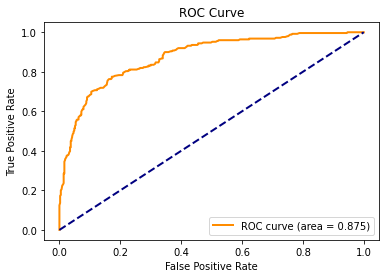

In [33]:
plot_roc(fprs, tprs, auc)

---
STAT 207, Julie Deeke, Victoria Ellison, and Douglas Simpson, University of Illinois at Urbana-Champaign